In [1]:
!python -m interp.train --approach mlp_diff --dataset all

Using device: cpu
Epoch 1/50: 100%|█████████████| 313/313 [00:27<00:00, 11.44batch/s, loss=1.1694]
Epoch 1/50, Training Loss: 5.1923
Epoch 1/50, Validation Loss: 2.3349
Saved best model to interp_checkpoints/trained_model.pth
Epoch 2/50: 100%|█████████████| 313/313 [00:26<00:00, 12.01batch/s, loss=0.9658]
Epoch 2/50, Training Loss: 2.2104
Epoch 2/50, Validation Loss: 1.7295
Saved best model to interp_checkpoints/trained_model.pth
Epoch 3/50: 100%|█████████████| 313/313 [00:26<00:00, 11.90batch/s, loss=0.9126]
Epoch 3/50, Training Loss: 1.7861
Epoch 3/50, Validation Loss: 1.4771
Saved best model to interp_checkpoints/trained_model.pth
Epoch 4/50: 100%|█████████████| 313/313 [00:26<00:00, 11.76batch/s, loss=0.7172]
Epoch 4/50, Training Loss: 1.5781
Epoch 4/50, Validation Loss: 1.3838
Saved best model to interp_checkpoints/trained_model.pth
Epoch 5/50: 100%|█████████████| 313/313 [00:26<00:00, 11.73batch/s, loss=0.5317]
Epoch 5/50, Training Loss: 1.4818
Epoch 5/50, Validation Loss: 1.2681

In [1]:
from interp.models import DummyModel
from interp.train import evaluate
from interp.dataset import HDF5Dataset, custom_collate
from torch.utils.data import DataLoader

val_dataset_ood = HDF5Dataset("data/interp_data_OOD_20_64.h5")
val_dataloader_ood = DataLoader(val_dataset_ood, batch_size=4, shuffle=True, collate_fn=custom_collate)
val_dataset_16 = HDF5Dataset("data/interp_data_16_eval.h5")
val_dataloader_16 = DataLoader(val_dataset_16, batch_size=4, shuffle=True, collate_fn=custom_collate)
val_dataset_8 = HDF5Dataset("data/interp_data_8_eval.h5")
val_dataloader_8 = DataLoader(val_dataset_8, batch_size=4, shuffle=True, collate_fn=custom_collate) 
val_dataset_all = HDF5Dataset("data/interp_data_all_lengths_eval.h5")
val_dataloader_all = DataLoader(val_dataset_all, batch_size=4, shuffle=True, collate_fn=custom_collate)


In [2]:
m = DummyModel()
print("performing evaluation on OOD dataset")
print(evaluate(m, val_dataloader_ood, "cpu"))
print("performing evaluation on 16 dataset")
print(evaluate(m, val_dataloader_16, "cpu"))
print("performing evaluation on 8 dataset")
print(evaluate(m, val_dataloader_8, "cpu"))
print("performing evaluation on all dataset")
print(evaluate(m, val_dataloader_all, "cpu"))


performing evaluation on OOD dataset
11.325214773079134
performing evaluation on 16 dataset
8.116012664794923
performing evaluation on 8 dataset
5.820901767730713
performing evaluation on all dataset
6.428800236337326


In [2]:
from interp.models import InterpNetwork, GNNInterpNetwork, GNNTransformerInterpNetwork
import torch

model = GNNTransformerInterpNetwork(hidden_dim=128)
model.load_state_dict(torch.load("interp_checkpoints/gnn_transf_model_all.pth"))
model.eval()

print("performing evaluation on OOD dataset")
print(evaluate(model, val_dataloader_ood, "cpu"))
print("performing evaluation on 16 dataset")
print(evaluate(model, val_dataloader_16, "cpu"))
print("performing evaluation on 8 dataset")
print(evaluate(model, val_dataloader_8, "cpu"))
print("performing evaluation on all dataset")
print(evaluate(model, val_dataloader_all, "cpu"))

performing evaluation on OOD dataset
1.0914266506491124
performing evaluation on 16 dataset
0.14479277934134008
performing evaluation on 8 dataset
0.05738540599361295
performing evaluation on all dataset
0.06280248628363053


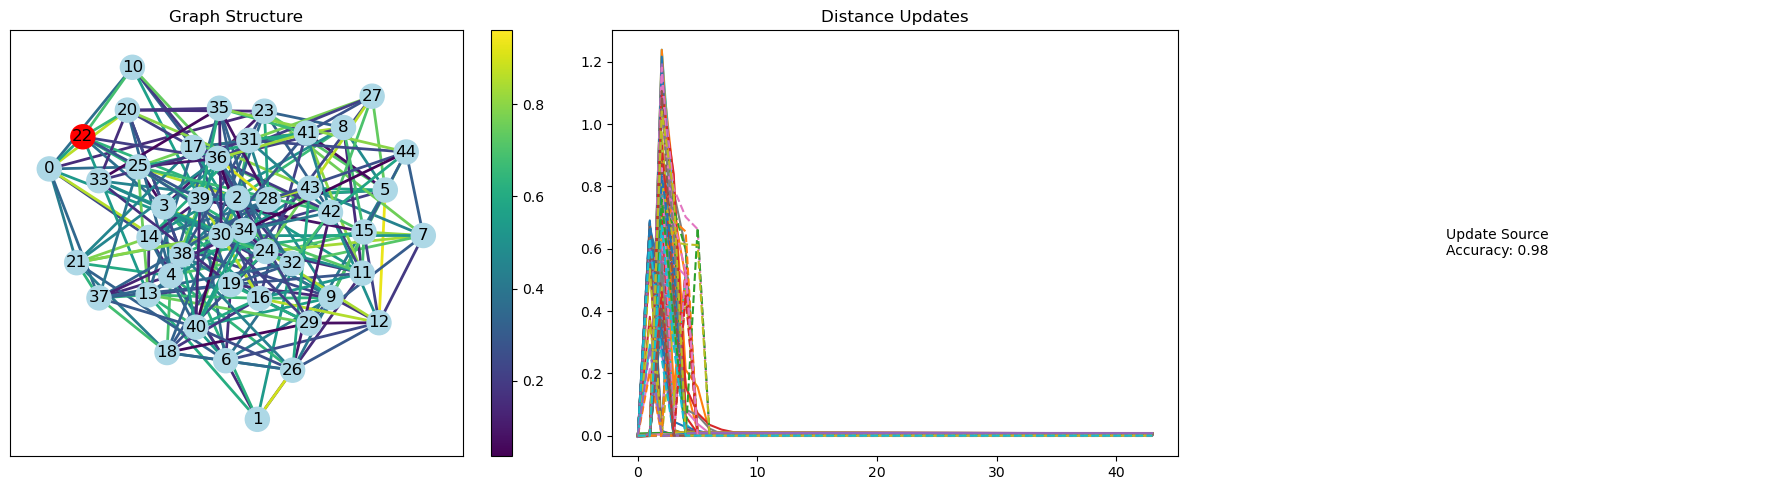

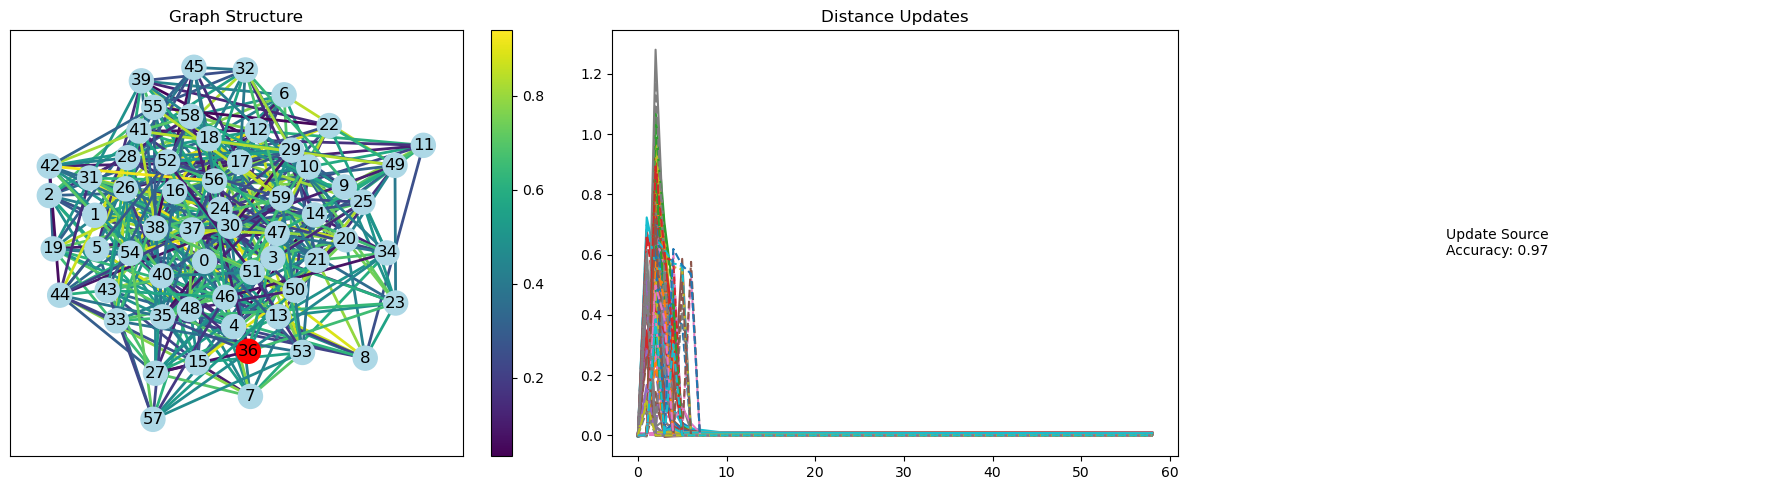

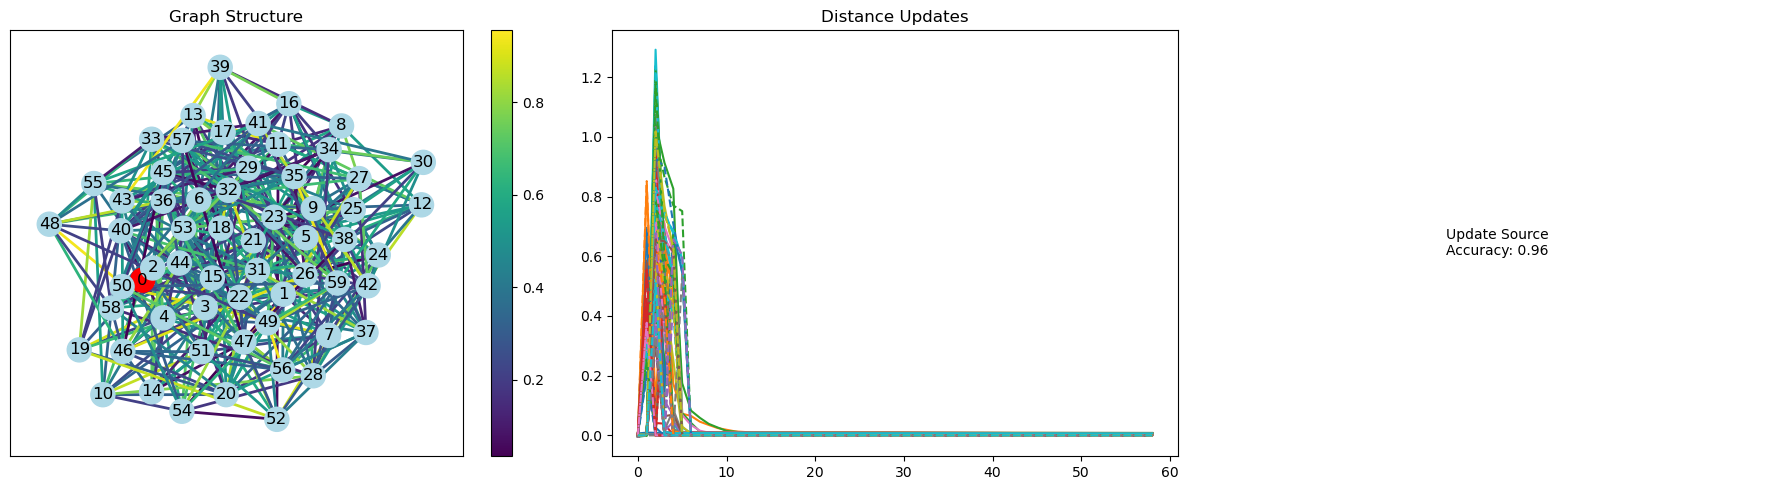

In [3]:
from interp.models import InterpNetwork
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import random

# Initialize model and load trained weights
model = InterpNetwork(hidden_dim=128)
model.load_state_dict(torch.load("interp_checkpoints/trained_model.pth"))
model.eval()

# Get a few examples from eval dataset
eval_dataset = HDF5Dataset("data/interp_data_OOD_20_64.h5")
num_examples = 3

for i in random.sample(range(len(eval_dataset)), num_examples):
    data = eval_dataset[i]
    
    # Get model predictions
    with torch.no_grad():
        # Prepare inputs according to train.py format
        hidden_states = data['hidden_states']  # (T, H, D)
        edge_weights = data['edge_weights'].float()  # (D, D)
        batch_info = torch.zeros(edge_weights.shape[0], dtype=torch.long)  # All nodes belong to batch 0
        num_graphs = torch.tensor(1)  # Single graph
        time_indices = torch.tensor([0, hidden_states.shape[0]])  # Start and end timesteps
        
        class_out, dist_out = model(hidden_states, edge_weights, batch_info, num_graphs, time_indices)
    
    # Plot results for this example
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
    
    # Plot graph structure with networkx
    # Create graph ignoring self-connections
    adj_matrix = data['graph_adj'].numpy()
    np.fill_diagonal(adj_matrix, 0)  # Zero out diagonal to ignore self connections
    G = nx.from_numpy_array(adj_matrix)
    pos = nx.spring_layout(G)
    
    # Draw edges with weights as colors, excluding self-loops
    edges = [(u,v) for (u,v) in G.edges() if u != v]
    edge_weights = [data['edge_weights'][u][v].item() for (u,v) in edges]
    
    # Draw nodes
    node_colors = ['red' if data['start_node'][j] == 1 else 'lightblue' for j in range(len(G.nodes()))]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, ax=ax1)
    
    # Draw edges with weights as colors and labels
    edge_collection = nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_weights, edge_cmap=plt.cm.viridis, width=2, ax=ax1)
    nx.draw_networkx_labels(G, pos, ax=ax1)
    
    # Create colorbar using ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
    plt.colorbar(sm, ax=ax1)
    
    ax1.set_title('Graph Structure')
    
    # Plot predicted vs actual distance updates
    ax2.plot(dist_out[0].numpy(), label='Predicted Updates')
    ax2.plot(data['upd_d'][:-1].numpy(), '--', label='Ground Truth')
    ax2.set_title('Distance Updates')
    #ax2.legend()
    
    # Plot update source accuracy
    pred_sources = torch.argmax(class_out[0], dim=-1)  # Get predicted source nodes
    true_sources = data['upd_pi'][:-1]  # Ground truth source nodes
    accuracy = (pred_sources == true_sources).float().mean()
    ax3.text(0.5, 0.5, f'Update Source\nAccuracy: {accuracy:.2f}', 
             horizontalalignment='center', verticalalignment='center')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()
